In [7]:
import numpy as np
from glob import glob
import xroms

import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")

In [33]:

def grid_dist_same(lon,lat):
    import seawater as sw
    if len(lon.shape)==2:
        grid_x=np.zeros(lon.shape)+np.nan
    else:
        grid_x=np.zeros([lat.shape[0],lon.shape[0]])
    
    grid_d=sw.dist(lon=lon,lat=lat)[0]
    grid_x[0:-1,:]=grid_d
    grid_x[-1,:]=grid_d[-1,:]
    
    return grid_x

def area_filter(lon,lat,filter_scale,dim_x,dim_y):
    #paramerers for convolution
    if dim_x=='xi_rho' and dim_y=='eta_rho':
    
        grid=grid_dist_same(lon,lat)
        gs=xr.DataArray(grid,dims=(dim_y,dim_x))

        radius = int( (filter_scale / gs.min().compute() / 2 ).round()) 
        # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing
        window_size = 2 * radius + 1


        gsr = gs.rolling(xi_rho=window_size,center=True).construct("lon_window").rolling(eta_rho=window_size, center=True).construct("lat_window")

        gsr_lat = gsr.cumsum("lat_window")
        gsr_lat -= gsr_lat.isel(lat_window=radius)
        gsr_lon = gsr.cumsum("lon_window")
        gsr_lon -= gsr_lon.isel(lon_window=radius)
        circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < filter_scale / 2)
        Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])
    return gs,radius,circ,Asum

    
def apply_area_filter(var,gs,radius,circ,Asum):
    
    window_size = 2 * radius + 1
    
    var_sm = var.copy()
    var_sm += np.nan;



    varA  = gs ** 2 * var # multiplication with area
    varAr = varA.rolling(xi_rho=window_size,center=True).construct("lon_window").rolling(eta_rho=window_size, center=True).construct("lat_window")
    var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
    var_sm_tmp2[radius:-radius,radius:-radius] = var_sm_tmp[radius:-radius,radius:-radius]
    var_sm[:] = var_sm_tmp2
    return var_sm


In [5]:

chunks={'time_counter':1,'x_rho':100,"x_u":100,"x_v":100,
                        'y_rho':152,"y_u":152,"y_v":152,'s_rho':80,'s_w':80}
path='/data/pacific/lrenault/SASI/CROCO/'


# varf=xr.open_mfdataset(path + 'FULL/SASI*2012-{0}*.nc'.format(M),data_vars='minimal')
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-{0}*.nc'.format(M),data_vars='minimal')

varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)

In [8]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

In [14]:
%time
rho_full=df.rho[:,-1,120:-120,120:800]+df.rho0
rho_smth=dt.rho[:,-1,120:-120,120:800]+dt.rho0

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 16.2 µs


In [15]:
g=9.8
b_full=-g*(rho_full-df.rho0)/df.rho0
b_smth=-g*(rho_smth-dt.rho0)/dt.rho0


In [45]:
z_star_full=xr.open_mfdataset('/data/pacific/iufarias/tseng_z_star/z_star_full*')['__xarray_dataarray_variable__'][:,0]
z_star_smth=xr.open_mfdataset('/data/pacific/iufarias/tseng_z_star/z_star_smth*')['__xarray_dataarray_variable__'][:,0]

# Filtering

In [34]:
%%time
scal=20

grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=b_full[0].nav_lon_rho.compute(),
                              lat=b_full[0].nav_lat_rho.compute(),
                              filter_scale=scal,dim_x='xi_rho',dim_y='eta_rho')



CPU times: user 28.3 s, sys: 12.2 s, total: 40.6 s
Wall time: 39.7 s


In [51]:
%%time

b_prime_full=[]
zstar_prime_full=[]

for i_x in range(124):

    A=apply_area_filter(b_full[i_x],gs=grid_croco,radius=scale_radius,circ=scale_circ,Asum=scale_areasum)
    B=apply_area_filter(z_star_full[i_x],gs=grid_croco,radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

    aa=b_full[i_x]-A
    bb=z_star_full[i_x]-B
    
    b_prime_full.append(A)
    zstar_prime_full.append(B)

KeyboardInterrupt: 

In [54]:
B_prime_full=xr.concat(b_prime_full,dim='ocean_time')
Zstar_prime_full=xr.concat(zstar_prime_full,dim='ocean_time')

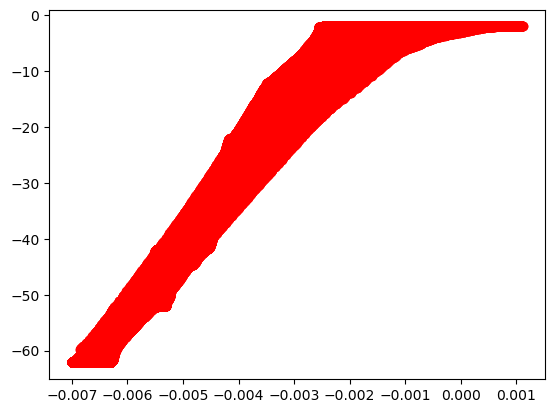

In [58]:
plt.plot(np.ravel(B_prime_full),np.ravel(Zstar_prime_full),'o',color='red')